In [1]:
import sys, os
sys.path.append(os.path.abspath('..'))  # só se o notebook estiver em sensibilidade/
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy import stats
import warnings
from src.pricing_model import simulate_pricing
from src.config import *

In [8]:
class AnaliseSensibilidade:
    def __init__(self, dados_reais=None):
        """
        Inicializa a análise de sensibilidade
        
        Args:
            dados_reais: DataFrame opcional com dados reais de spread
        """
        self.dados_reais = dados_reais
        self.variaveis_base = {
            # Seção 1: Variáveis de Risco de Negócio
            'p_close_annual': 0.10,  # exemplo: 10% a.a.
            'p_rot_m': 0.02,        # exemplo: 2% a.m.
            'P_INFORMALIDADE': P_INFORMALIDADE,
            'LGD': LGD,
            
            # Seção 2: Variáveis Financeiras Base
            'CDI_ANUAL': CDI_ANUAL,
            'FUNDING': FUNDING,
            'CUSTO_OPERACIONAL': CUSTO_OPERACIONAL,
            'MARGEM': MARGEM,
            
            # Seção 3: Variáveis de Características do Empréstimo
            'PV': 10000,  # exemplo: R$ 10.000
            'n': 24,      # exemplo: 24 meses
            'delay': 3    # exemplo: 3 meses de atraso
        }
        
    def variar_uma_variavel(self, variavel, valores, fixar_outras=None):
        """
        Analisa o impacto de variar uma única variável no spread
        
        Args:
            variavel: Nome da variável a ser variada
            valores: Lista de valores para testar
            fixar_outras: Dict com valores fixos para outras variáveis (opcional)
            
        Returns:
            DataFrame com resultados
        """
        resultados = []
        params = self.variaveis_base.copy()
        if fixar_outras:
            params.update(fixar_outras)
            
        for valor in valores:
            params[variavel] = valor
            try:
                resultado = simulate_pricing(params)
                resultados.append({
                    variavel: valor,
                    'spread_anual': resultado['spread_anual'],
                    'PMT_risco': resultado['PMT_risco']
                })
            except Exception as e:
                warnings.warn(f"Erro ao calcular para {variavel}={valor}: {e}")
                
        return pd.DataFrame(resultados)
    
    def variar_par_variaveis(self, var1, var2, valores1, valores2, fixar_outras=None):
        """
        Analisa o impacto de variar duas variáveis simultaneamente
        
        Args:
            var1, var2: Nomes das variáveis
            valores1, valores2: Listas de valores para testar
            fixar_outras: Dict com valores fixos para outras variáveis (opcional)
            
        Returns:
            DataFrame com resultados
        """
        resultados = []
        params = self.variaveis_base.copy()
        if fixar_outras:
            params.update(fixar_outras)
            
        for v1 in valores1:
            for v2 in valores2:
                params[var1] = v1
                params[var2] = v2
                try:
                    resultado = simulate_pricing(params)
                    resultados.append({
                        var1: v1,
                        var2: v2,
                        'spread_anual': resultado['spread_anual'],
                        'PMT_risco': resultado['PMT_risco']
                    })
                except Exception as e:
                    warnings.warn(f"Erro ao calcular para {var1}={v1}, {var2}={v2}: {e}")
                    
        return pd.DataFrame(resultados)
    
    def analise_correlacao_dados_reais(self, show=True):
        """
        Analisa correlações entre variáveis usando dados reais
        Returns: DataFrame com matriz de correlação
        """
        if self.dados_reais is None:
            raise ValueError("Dados reais não fornecidos")
            
        # Use apenas as colunas que existem e variam no CSV
        variaveis = [
            'p_close_annual', 'p_rot_m', 'delay', 'PV', 'n', 
            # adicione outras colunas do CSV que variam
            'spread_anual'
        ]
        variaveis = [v for v in variaveis if v in self.dados_reais.columns]
        corr = self.dados_reais[variaveis].corr()
        fig = None
        if show:
            fig, ax = plt.subplots(figsize=(10, 8))
            sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', center=0, ax=ax)
            plt.title('Correlação entre Variáveis (Dados Reais)')
            plt.show()
        return corr if not show else (corr, fig)
    
    def plot_sensibilidade_individual(self, variavel, valores, fixar_outras=None):
        """
        Plota o gráfico de sensibilidade para uma variável
        
        Args:
            variavel: Nome da variável
            valores: Lista de valores para testar
            fixar_outras: Dict com valores fixos para outras variáveis (opcional)
        """
        df = self.variar_uma_variavel(variavel, valores, fixar_outras)
        
        plt.figure(figsize=(10, 6))
        plt.plot(df[variavel], df['spread_anual'], 'b-', label='Spread Anual')
        plt.plot(df[variavel], df['PMT_risco'], 'r--', label='PMT Risco')
        plt.xlabel(variavel)
        plt.ylabel('Valor')
        plt.title(f'Sensibilidade do Spread à {variavel}')
        plt.legend()
        plt.grid(True)
        plt.show()
    
    def plot_sensibilidade_par(self, var1, var2, valores1, valores2, fixar_outras=None):
        """
        Plota o gráfico de sensibilidade para um par de variáveis
        
        Args:
            var1, var2: Nomes das variáveis
            valores1, valores2: Listas de valores para testar
            fixar_outras: Dict com valores fixos para outras variáveis (opcional)
        """
        df = self.variar_par_variaveis(var1, var2, valores1, valores2, fixar_outras)
        
        # Cria matriz de spread para o heatmap
        spread_matrix = df.pivot(index=var1, columns=var2, values='spread_anual')
        
        plt.figure(figsize=(12, 8))
        sns.heatmap(spread_matrix, annot=True, fmt='.2f', cmap='YlOrRd')
        plt.title(f'Sensibilidade do Spread a {var1} e {var2}')
        plt.show()
    
    def plot_correlacao_dados_reais(self):
        """
        Plota a matriz de correlação dos dados reais
        """
        if self.dados_reais is None:
            raise ValueError("Dados reais não fornecidos")
            
        corr = self.analise_correlacao_dados_reais()
        
        plt.figure(figsize=(12, 10))
        sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', center=0)
        plt.title('Correlação entre Variáveis (Dados Reais)')
        plt.show()
        
    def analise_distribuicao_spread(self, show=True):
        """
        Analisa a distribuição do spread nos dados reais
        """
        if self.dados_reais is None:
            raise ValueError("Dados reais não fornecidos")
        
        fig, axs = plt.subplots(1, 2, figsize=(12, 6))
        
        # Histograma do spread
        sns.histplot(data=self.dados_reais, x='spread_anual', bins=50, ax=axs[0])
        axs[0].set_title('Distribuição do Spread Anual')
        axs[0].set_xlabel('Spread Anual')
        axs[0].set_ylabel('Frequência')
        
        # Box plot do spread por CNAE (remover NaN e filtrar categorias com poucos exemplos)
        df = self.dados_reais.dropna(subset=['cnae_section', 'spread_anual'])
        counts = df['cnae_section'].value_counts()
        valid_sections = counts[counts > 5].index  # Pelo menos 6 exemplos
        df = df[df['cnae_section'].isin(valid_sections)]
        sns.boxplot(data=df, x='cnae_section', y='spread_anual', ax=axs[1])
        axs[1].set_title('Spread Anual por Setor (CNAE)')
        axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=45)
        fig.tight_layout()
        if show:
            plt.show()
        return fig

    def analise_spread_por_porte(self):
        """
        Ignora a coluna 'porte' pois está vazia.
        """
        warnings.warn("Coluna 'porte' está vazia e será ignorada nesta análise.")

    def analise_spread_por_tempo_empresa(self, show=True):
        """
        Analisa o spread em relação ao tempo de empresa
        """
        if self.dados_reais is None:
            raise ValueError("Dados reais não fornecidos")
        fig, ax = plt.subplots(figsize=(10, 6))
        sns.scatterplot(data=self.dados_reais, x='tempo_empresa_anos', y='spread_anual', alpha=0.5, ax=ax)
        ax.set_title('Spread Anual vs Tempo de Empresa')
        ax.set_xlabel('Tempo de Empresa (anos)')
        ax.set_ylabel('Spread Anual')
        if show:
            plt.show()
        return fig

    def analise_spread_por_valor_emprestimo(self, show=True):
        """
        Analisa o spread em relação ao valor do empréstimo
        """
        if self.dados_reais is None:
            raise ValueError("Dados reais não fornecidos")
        fig, ax = plt.subplots(figsize=(10, 6))
        sns.scatterplot(data=self.dados_reais, x='PV', y='spread_anual', alpha=0.5, ax=ax)
        ax.set_title('Spread Anual vs Valor do Empréstimo')
        ax.set_xlabel('Valor do Empréstimo (PV)')
        ax.set_ylabel('Spread Anual')
        if show:
            plt.show()
        return fig

    def analise_regressao_multipla(self, explicativas=None, resposta='spread_anual', normalize=False, as_df=True):
        import statsmodels.api as sm
        from sklearn.preprocessing import StandardScaler
        if self.dados_reais is None:
            raise ValueError("Dados reais não fornecidos")
        if explicativas is None:
            explicativas = ['p_close_annual', 'p_rot_m', 'delay', 'PV', 'n']
        explicativas = [v for v in explicativas if v in self.dados_reais.columns]
        df = self.dados_reais.dropna(subset=explicativas + [resposta])
        X = df[explicativas]
        if normalize:
            scaler = StandardScaler()
            X = pd.DataFrame(scaler.fit_transform(X), columns=explicativas, index=X.index)
        X = sm.add_constant(X)
        y = df[resposta]
        model = sm.OLS(y, X).fit()
        if as_df:
            summary_df = pd.DataFrame({
                'coef': model.params,
                'std_err': model.bse,
                't': model.tvalues,
                'p_value': model.pvalues
            })
            return model, summary_df
        else:
            print(model.summary())
            return model

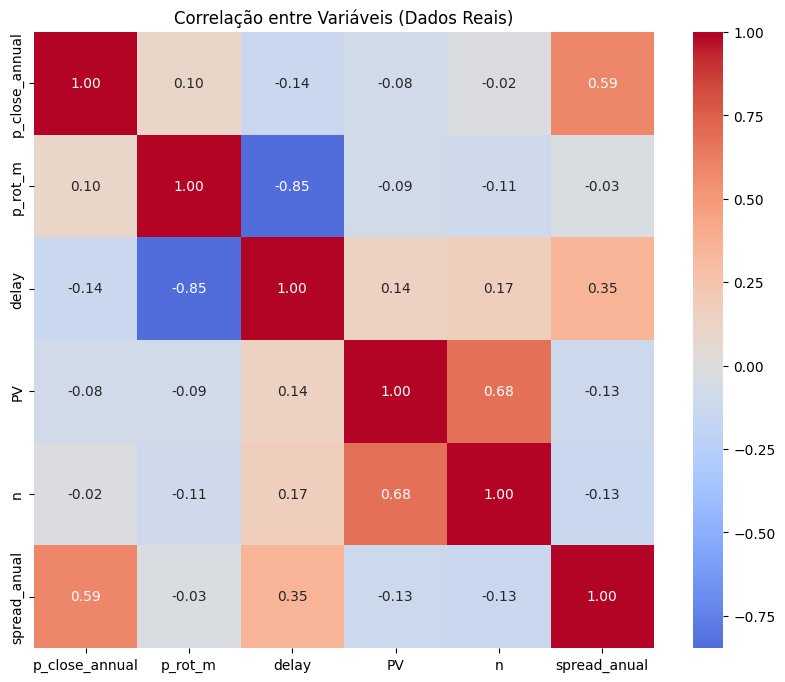

,coef,std_err,t,p_value
const,-1.131148e-02,9.213546e-05,-122.770094,0.000000e+00
p_close_annual,1.829915e-01,2.051960e-04,891.788699,0.000000e+00
p_rot_m,1.134320e+00,1.515550e-03,748.454241,0.000000e+00
delay,5.246484e-03,5.390453e-06,973.291931,0.000000e+00
PV,-7.402608e-08,5.115780e-09,-14.470146,1.959540e-47
n,-4.820046e-04,2.128614e-06,-226.440540,0.000000e+00


In [3]:
dados = pd.read_csv('../resultados/resultado_pricingv1_2025-05-19.csv')
analise = AnaliseSensibilidade(dados_reais=dados)
corr, fig = analise.analise_correlacao_dados_reais()
model, summary = analise.analise_regressao_multipla()
display(summary)

C:\Users\rodrigo.miranda_meut\AppData\Local\Temp\ipykernel_16192\116994798.py:194: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=45)


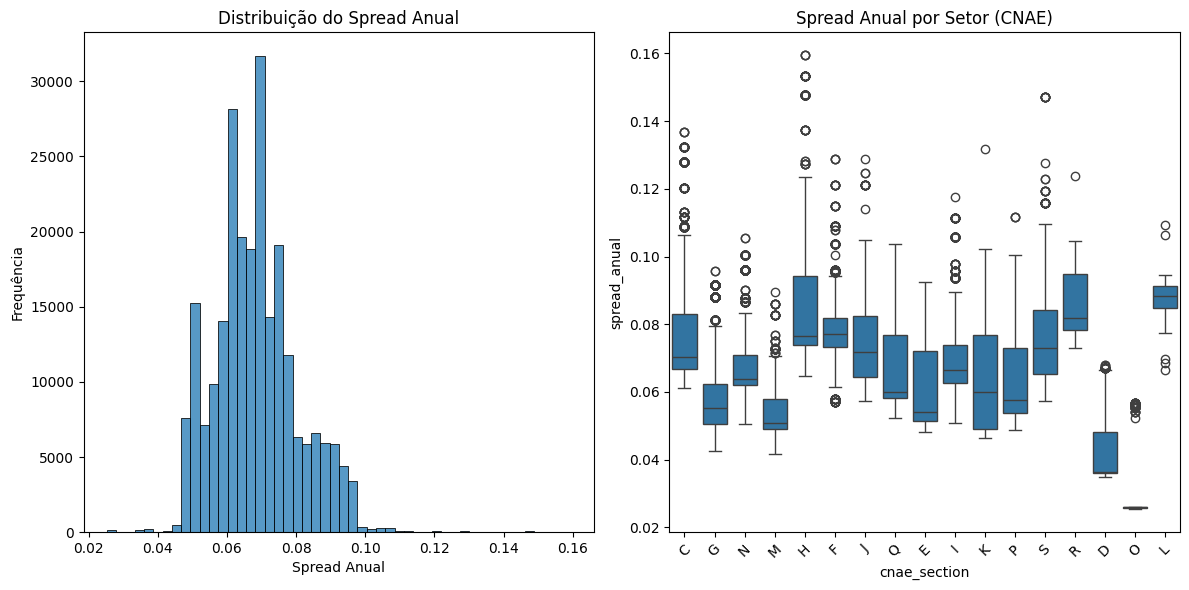

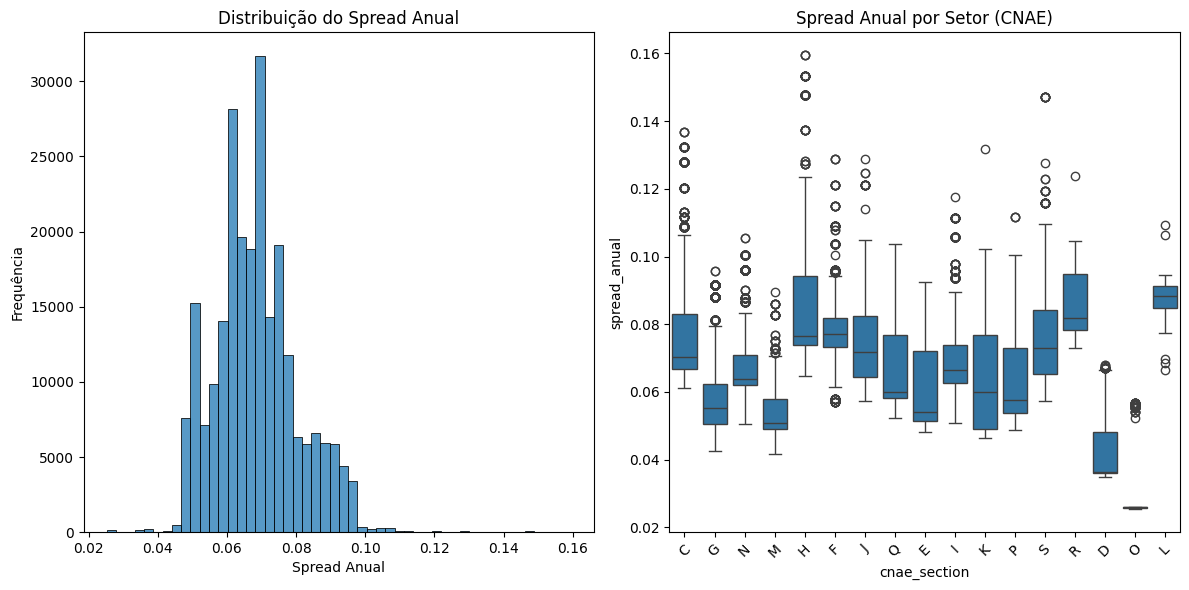

In [4]:
# Mostra histograma do spread anual e boxplot por CNAE
analise.analise_distribuicao_spread(show=False)

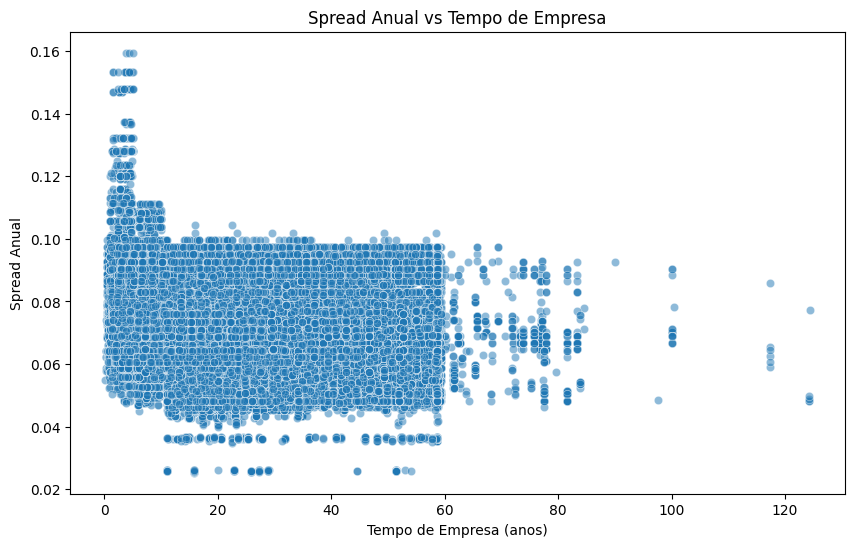

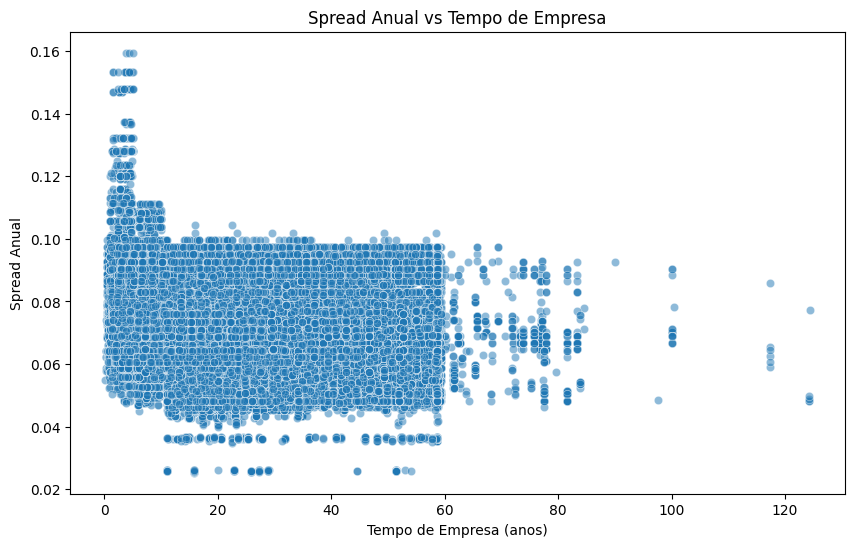

In [5]:
analise.analise_spread_por_tempo_empresa()

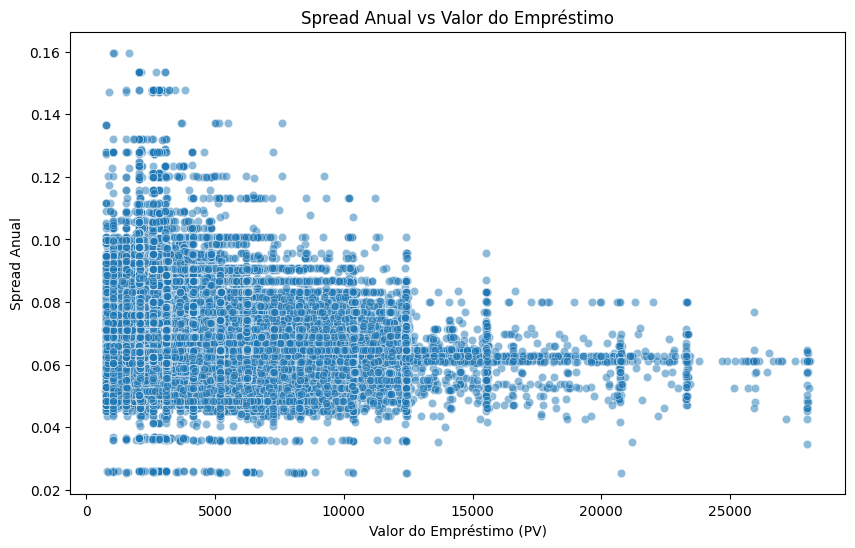

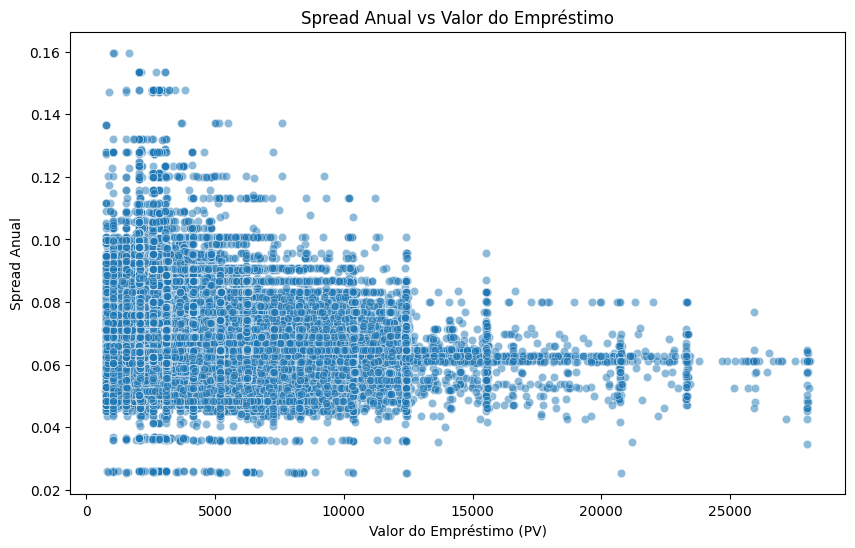

In [6]:
analise.analise_spread_por_valor_emprestimo()

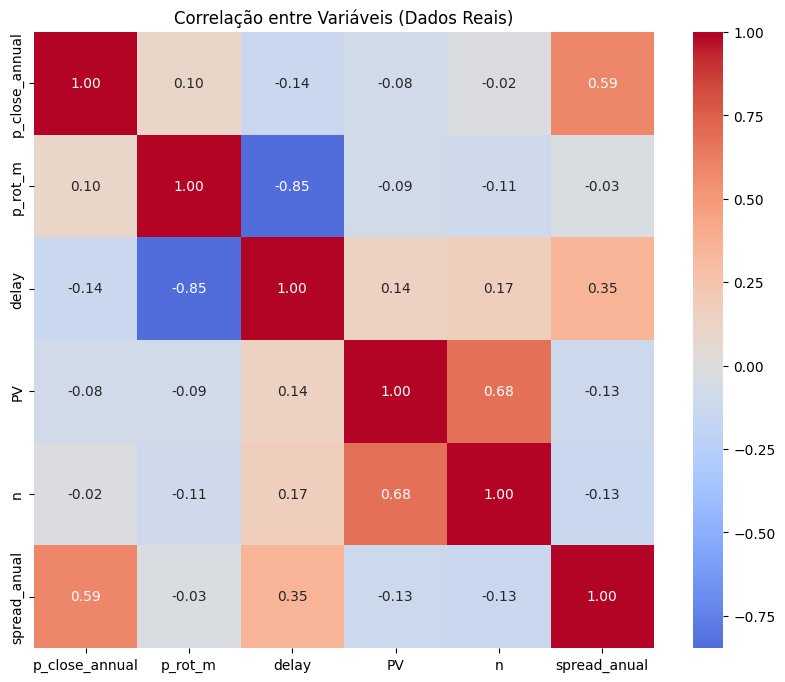

(                p_close_annual   p_rot_m     delay        PV         n  \
 p_close_annual        1.000000  0.102144 -0.136781 -0.084822 -0.021491   
 p_rot_m               0.102144  1.000000 -0.847353 -0.087640 -0.106772   
 delay                -0.136781 -0.847353  1.000000  0.139651  0.166707   
 PV                   -0.084822 -0.087640  0.139651  1.000000  0.679944   
 n                    -0.021491 -0.106772  0.166707  0.679944  1.000000   
 spread_anual          0.585760 -0.026721  0.354341 -0.125580 -0.134814   
 
                 spread_anual  
 p_close_annual      0.585760  
 p_rot_m            -0.026721  
 delay               0.354341  
 PV                 -0.125580  
 n                  -0.134814  
 spread_anual        1.000000  ,
 <Figure size 1000x800 with 2 Axes>)

In [7]:
analise.analise_correlacao_dados_reais()

In [9]:
model, summary = analise.analise_regressao_multipla()
display(summary)

,coef,std_err,t,p_value
const,-1.131148e-02,9.213546e-05,-122.770094,0.000000e+00
p_close_annual,1.829915e-01,2.051960e-04,891.788699,0.000000e+00
p_rot_m,1.134320e+00,1.515550e-03,748.454241,0.000000e+00
delay,5.246484e-03,5.390453e-06,973.291931,0.000000e+00
PV,-7.402608e-08,5.115780e-09,-14.470146,1.959540e-47
n,-4.820046e-04,2.128614e-06,-226.440540,0.000000e+00
